In [1]:
import bayestorch as bt
from bayestorch import Parameter,Data,Variable,optimizing,vb,sampling,reset
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [2]:
from bayestorch.data.battle import friend_point,enemy_point,battle_point

In [3]:
_enemy_point = enemy_point.copy() #备份enemy_point，按当前这个脑残实现这个enemy_point状态会被改变

In [4]:
# display data
def display_data():
    plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
    plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
    plt.scatter(battle_point[:,0],battle_point[:,1],color='green',label='battle')
    plt.legend()


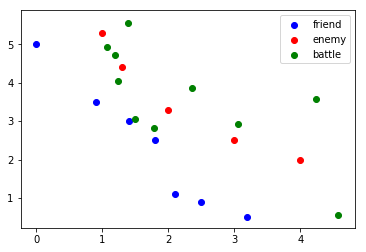

In [5]:
display_data()
plt.show()


OK，把代码全整理成一个包后那些样板代码总算没有那么难看了。下面我们来考虑如何扩展到不是真实数量的enemy个数的情况。

In [6]:
# transformed data

X = np.vstack([friend_point, enemy_point])
Y = np.ones(X.shape[0],dtype=int)
Y[:friend_point.shape[0]] = 0


_logPC = np.log(np.array([np.sum(Y==0)/len(Y),np.sum(Y==1)/len(Y)]))


In [7]:
from bayestorch.distributions import norm_log_prob
from bayestorch.classifier import norm_naive_bayes_predict
from bayestorch.utils import GridSampler2d,cdist,soft_cut_ge,soft_cut_le

model = bt.core.current_model

In [8]:
# model
friend = Data(friend_point)
battle = Data(battle_point)
enemy = Parameter(enemy_point) # set real value as init value, though maybe a randomed init is more proper

logPC = Data(_logPC)

conflict_threshold = 0.2
distance_threshold = 1.0
tense = 10.0
alpha = 5.0
prior_threshold = 5.0
prior_tense = 5.0

def target():
    friend_enemy = torch.cat((friend, enemy),0)
    distance = cdist(battle, friend_enemy).min(dim=1)[0]
    

    mu = Variable(torch.zeros(2,2)) #目前外层还有个同名的numpy.array mu,sd变量不要搞混了
    sd = Variable(torch.zeros(2,2))
    
    mu[0,:] = friend.mean(dim=0)
    mu[1,:] = enemy.mean(dim=0)
    sd[0,:] = friend.std(dim=0)
    sd[1,:] = enemy.std(dim=0)
    
    conflict = torch.exp(norm_naive_bayes_predict(battle, mu, sd, logPC)).prod(dim=1)
    p = soft_cut_ge(conflict,conflict_threshold, tense = tense) * soft_cut_le(distance, distance_threshold, tense = tense)
    
    target= torch.sum(torch.log(p))
    return target

def target2():
    target1 = target()
    # location prior
    target2 = target1 + torch.sum(enemy.sum(dim=1))
    return target2

In [9]:
def show_change(show=False):
    display_data()
    for i in range(enemy_point.shape[0]):
        #s = 0.1
        plt.arrow(enemy_point[i][0], enemy_point[i][1], enemy.data[i][0] - enemy_point[i][0], enemy.data[i][1] - enemy_point[i][1],head_width=0.1)
    plt.legend()
    if show:
        plt.show()


def show_ellipse(mu,sd):
    from matplotlib.patches import Ellipse
    
    #ax = plt.subplot(111)
    ax = plt.gca() # get current axe, the lame method to support command style
    show_change(show=False)
    #res_reshaped = [r.reshape(enemy_point.shape) for r in res]
    for i in range(enemy_point.shape[0]):
        mu_x,mu_y = mu[i]
        sd_x,sd_y = sd[i]
        e=Ellipse((mu_x,mu_y), sd_x, sd_y, 0)
        e.set_clip_box(ax.bbox)
        e.set_alpha(0.1)
        ax.add_artist(e)
        
    #plt.show()
    
    
def show_vb(vb_res):
    res = vb_res
    model.set_parameter(res[0])
    res_reshaped = [r.reshape(enemy_point.shape) for r in res]
    mu = res_reshaped[0]
    sd = np.exp(res_reshaped[1])
    show_ellipse(mu,sd)


In [10]:
def reset_enemy(_enemy_point):
    global friend,battle,enemy,logPC
    global enemy_point
    reset() #状态机模型只能这么写了，感觉这么设计还是不好。。要么和闭包什么什么打交道更日dog
    enemy_point = _enemy_point
    
    friend = Data(friend_point)
    battle = Data(battle_point)
    enemy = Parameter(_enemy_point) # set real value as init value, though maybe a randomed init is more proper
    logPC = Data(_logPC)


In [11]:
def multi_enemy_setting_show(_enemy_point, target, title_string):
    reset_enemy(_enemy_point)
    res = vb(target)
    show_vb(res)
    #plt.title(title_string.format(i))
    plt.gca().set_title(title_string.format(i))
    plt.legend()
    #plt.show()


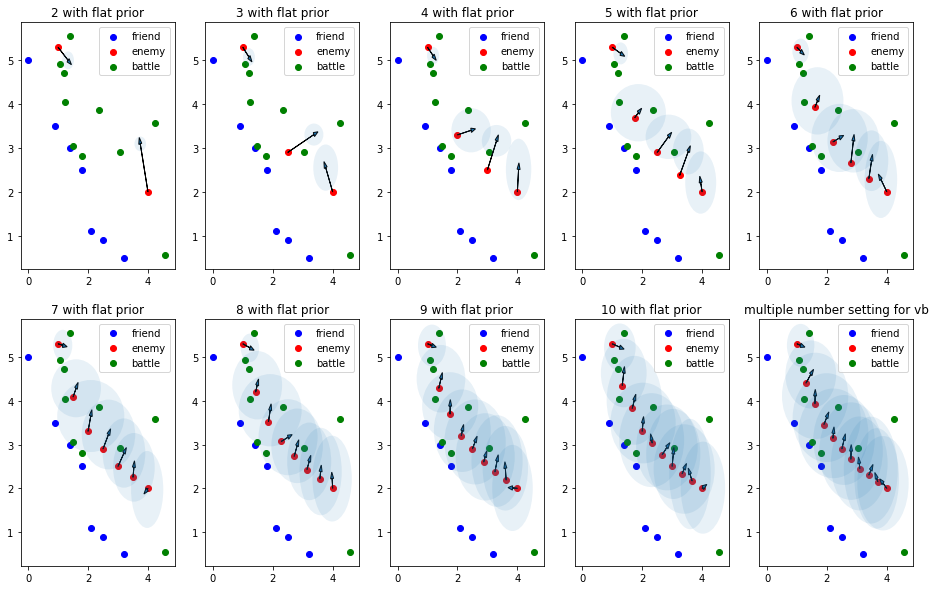

In [12]:
plt.figure(figsize=(16,10))
for i in range(2, 12):
    interp_x = np.linspace(_enemy_point[:,0].min(),_enemy_point[:,0].max(),i)
    interp_y = np.interp(interp_x, _enemy_point[:,0], _enemy_point[:,1])
    interp_xy = np.c_[interp_x,interp_y]
    plt.subplot(2, 5, i-1)
    multi_enemy_setting_show(interp_xy, target , '{} with flat prior')
'''
for i in range(2, 12):
    interp_x = np.linspace(_enemy_point[:,0].min(),_enemy_point[:,0].max(),i)
    interp_y = np.interp(interp_x, _enemy_point[:,0], _enemy_point[:,1])
    interp_xy = np.c_[interp_x,interp_y]
    plt.subplot(2, 5, i-1)
    multi_enemy_setting_show(interp_xy, target2 , '{} with diag prior')
'''
    #multi_enemy_setting_show(interp_xy, target2, '{} with diag prior')
plt.title('multiple number setting for vb')
plt.show()

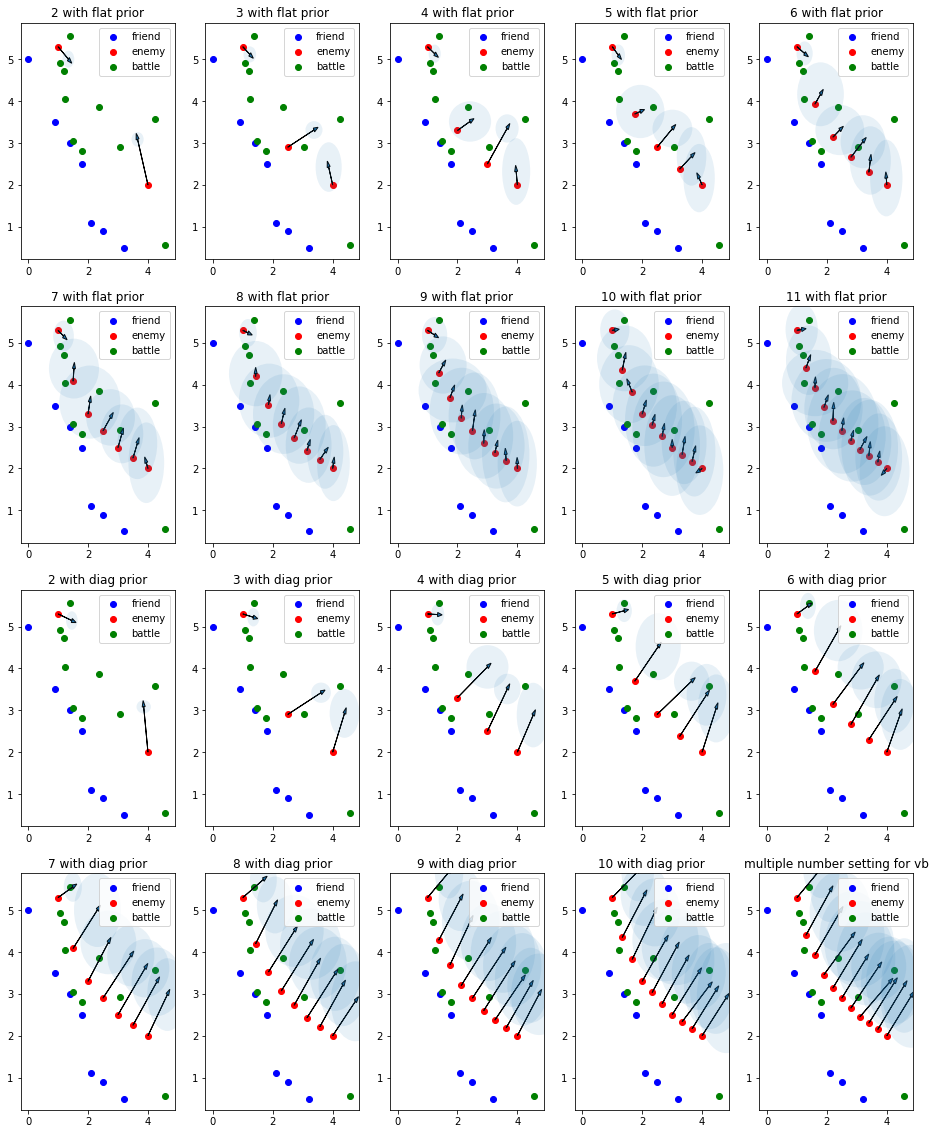

In [13]:
plt.figure(figsize=(16,20)) #(x,y)
for i in range(2, 12):
    interp_x = np.linspace(_enemy_point[:,0].min(),_enemy_point[:,0].max(),i)
    interp_y = np.interp(interp_x, _enemy_point[:,0], _enemy_point[:,1])
    interp_xy = np.c_[interp_x,interp_y]
    plt.subplot(4, 5, i-1)
    multi_enemy_setting_show(interp_xy, target , '{} with flat prior')

for i in range(2, 12):
    interp_x = np.linspace(_enemy_point[:,0].min(),_enemy_point[:,0].max(),i)
    interp_y = np.interp(interp_x, _enemy_point[:,0], _enemy_point[:,1])
    interp_xy = np.c_[interp_x,interp_y]
    plt.subplot(4, 5, 10+i-1)
    multi_enemy_setting_show(interp_xy, target2 , '{} with diag prior')

    #multi_enemy_setting_show(interp_xy, target2, '{} with diag prior')
plt.title('multiple number setting for vb')
plt.show()

这结果看起来还不错，现在我们希望考虑我们最开始使用这种模型想得到的东西，即计算一个点出现敌人的概率（密度）。

In [14]:
import scipy.stats as stats

In [131]:
def prob_point(x,y,dx,dy,_mu,_omega):
    """计算各个潜在敌人点在指定区域出现的后验概率"""
    mu = _mu.reshape(enemy_point.shape)
    sigma = np.exp(_omega.reshape(enemy_point.shape))
    x = np.reshape(x,(-1,1))
    y = np.reshape(y,(-1,1))
    px  = stats.norm.cdf((x-mu[:,0])/sigma[:,0])
    pdx = stats.norm.cdf((x+dx-mu[:,0])/sigma[:,0])
    py  = stats.norm.cdf((y-mu[:,1])/sigma[:,1])
    pdy = stats.norm.cdf((y+dy-mu[:,1])/sigma[:,1])
    '''
    print(px)
    print(pdx)
    print(py)
    print(pdy)
    print(pdx - px)
    print(pdy - py)
    print((pdx - px) * (pdy - py))
    print(1 - ((pdx - px) * (pdy - py)))
    print((1 - ((pdx - px) * (pdy - py))).T)
    print(np.prod((1 - ((pdx - px) * (pdy - py))).T,axis=0))
    print(1-np.prod((1 - (pdx - px) * (pdy - py)).T,axis=0))
    '''
    return (pdx - px) * (pdy - py) #wrong computation method

def prob_exist(x,y,dx,dy,_mu,_omega):
    ememy_prob = prob_point(x,y,dx,dy,_mu,_omega)
    return 1-np.prod((1 - ememy_prob).T,axis=0) #这么写是为了同时处理向量的矩阵对最后一维求prod

def prob_exist_limit(x,y,_mu,_omega,step=0.1):
    p = prob_exist(x-step,y-step,2*step,2*step,_mu,_omega)
    return p/(4*step*step)

In [25]:
reset_enemy(_enemy_point)

In [26]:
res = vb(target)

In [37]:
res[0]

array([1.24398138, 5.18459406, 1.61543264, 4.34193472, 2.5494302 ,
       3.50778825, 3.50920508, 3.09188628, 4.02921998, 2.165736  ])

In [38]:
res[1]

array([-0.6519223 , -0.57943471,  0.3303963 ,  0.36169095,  0.46201524,
        0.21583836, -0.0257489 , -0.00847598, -0.24743137,  0.44256285])

In [77]:
prob_point(2,3,1,1,res[0],res[1])

array([[0.00125494, 0.05339867, 0.07734995, 0.08566265, 0.01573238]])

In [78]:
prob_exist(2,3,1,1,res[0],res[1])

array([0.21498417])

In [81]:
prob_exist_limit(2,3,res[0],res[1],step=0.01)

array([0.69175371])

In [82]:
prob_exist_limit(2,3,res[0],res[1],step=0.01)

array([0.69175371])

In [83]:
prob_exist_limit(2,3,res[0],res[1],step=0.001)

array([0.69177134])

In [84]:
prob_exist_limit(4,5,res[0],res[1])

array([0.36006527])

In [85]:
prob_exist_limit(np.array([[2],[4]]),np.array([[3],[5]]),res[0],res[1])

array([0.68999215, 0.36006527])

In [132]:
_x = np.linspace(0,5,100)
_y = np.linspace(1,6,100)

xx,yy = np.meshgrid(_x,_y)
xy = np.c_[xx.ravel(),yy.ravel()]

In [133]:
p_exist = prob_exist_limit(xy[:,0],xy[:,1],res[0],res[1],step=0.001).reshape(xx.shape)

<a list of 10 text.Text objects>

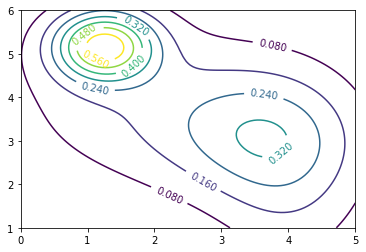

In [134]:
CS = plt.contour(xx,yy,p_exist)
#plt.contour(xx, yy, p_exist)
plt.clabel(CS)

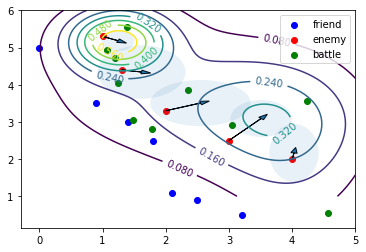

In [135]:
CS = plt.contour(xx,yy,p_exist)
#plt.contour(xx, yy, p_exist)
plt.clabel(CS)
show_vb(res)

In [138]:
def multi_enemy_setting_show_exist_density(_enemy_point, target, title_string):
    reset_enemy(_enemy_point)
    res = vb(target)
    show_vb(res)
    p_exist = prob_exist_limit(xy[:,0],xy[:,1],res[0],res[1],step=0.001).reshape(xx.shape)
    CS = plt.contour(xx,yy,p_exist)
    #plt.contour(xx, yy, p_exist)
    plt.clabel(CS)
    #plt.title(title_string.format(i))
    plt.gca().set_title(title_string.format(i))
    plt.legend()


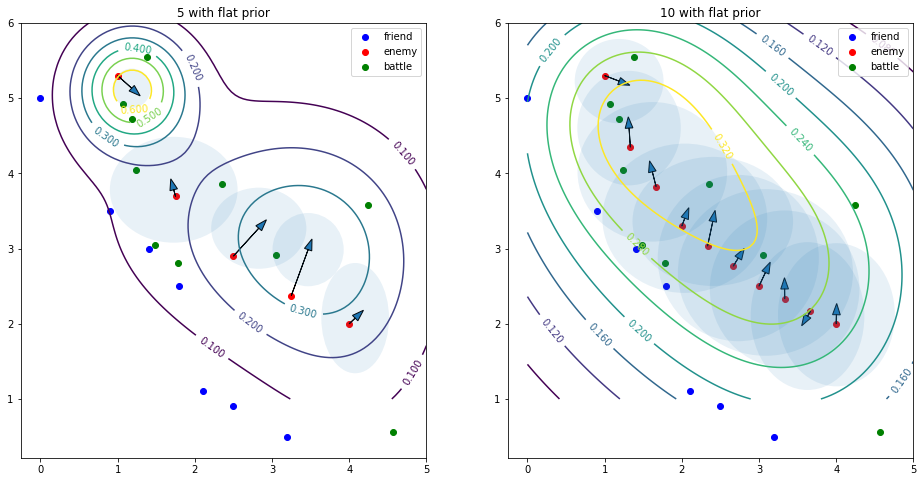

In [144]:
plt.figure(figsize=(16,8)) #(x,y)
for i in [5,10]:
    interp_x = np.linspace(_enemy_point[:,0].min(),_enemy_point[:,0].max(),i)
    interp_y = np.interp(interp_x, _enemy_point[:,0], _enemy_point[:,1])
    interp_xy = np.c_[interp_x,interp_y]
    plt.subplot(1, 2, i//5)
    multi_enemy_setting_show_exist_density(interp_xy, target , '{} with flat prior')


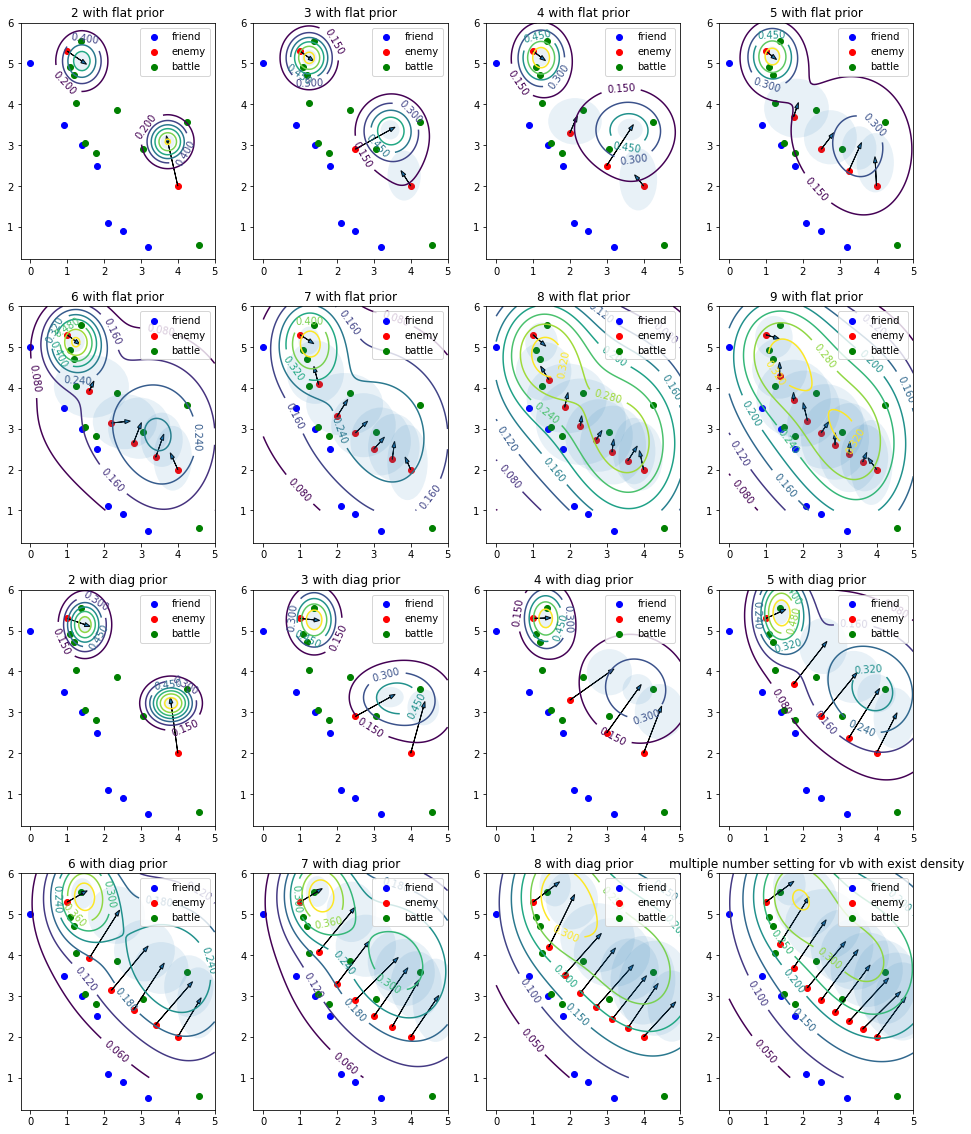

In [140]:
plt.figure(figsize=(16,20)) #(x,y)
for i in range(2, 10):
    interp_x = np.linspace(_enemy_point[:,0].min(),_enemy_point[:,0].max(),i)
    interp_y = np.interp(interp_x, _enemy_point[:,0], _enemy_point[:,1])
    interp_xy = np.c_[interp_x,interp_y]
    plt.subplot(4, 4, i-1)
    multi_enemy_setting_show_exist_density(interp_xy, target , '{} with flat prior')

for i in range(2, 10):
    interp_x = np.linspace(_enemy_point[:,0].min(),_enemy_point[:,0].max(),i)
    interp_y = np.interp(interp_x, _enemy_point[:,0], _enemy_point[:,1])
    interp_xy = np.c_[interp_x,interp_y]
    plt.subplot(4, 4, 8+i-1)
    multi_enemy_setting_show_exist_density(interp_xy, target2 , '{} with diag prior')

    #multi_enemy_setting_show(interp_xy, target2, '{} with diag prior')
plt.title('multiple number setting for vb with exist density')
plt.show()

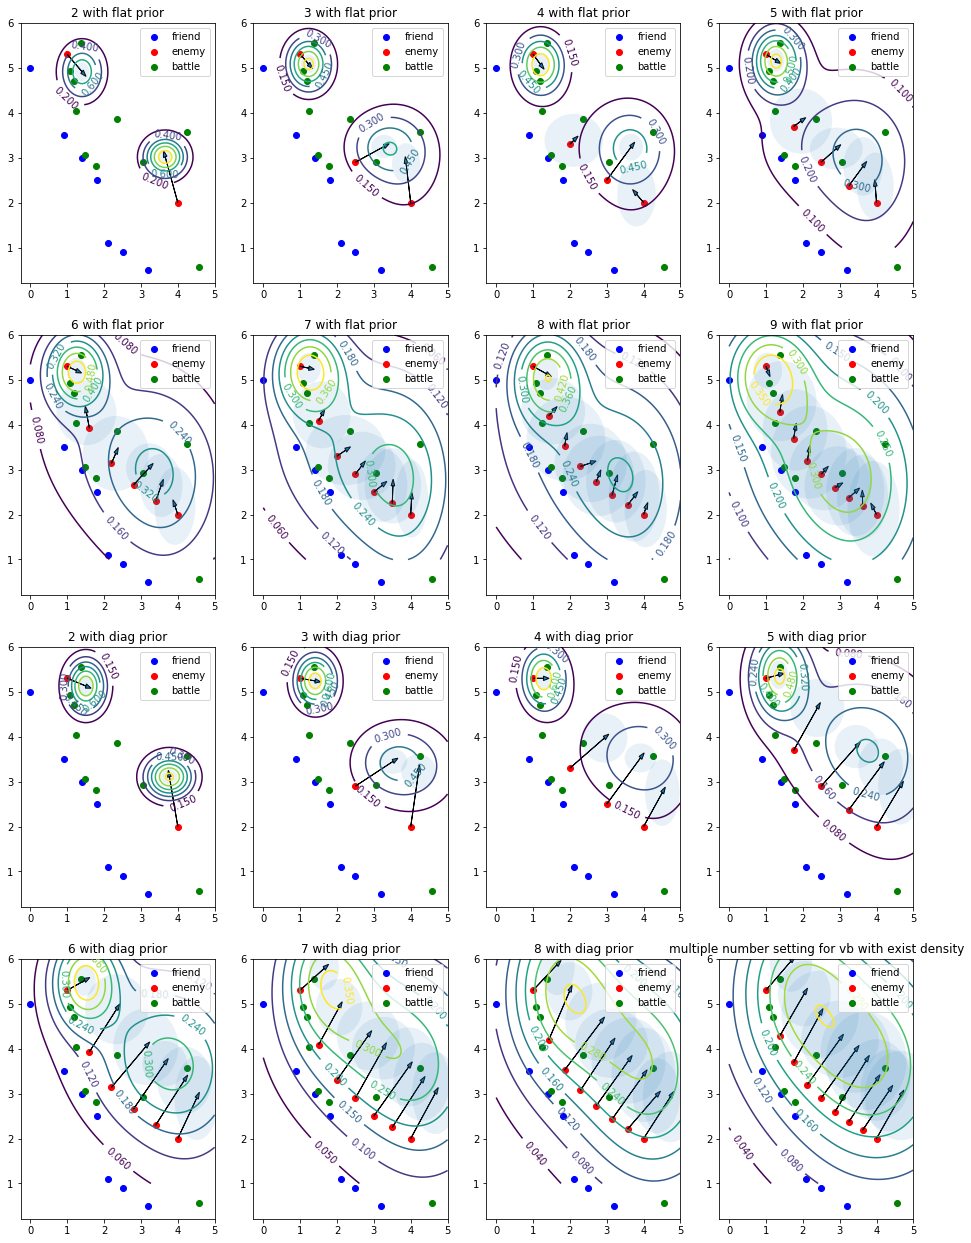

In [141]:
plt.figure(figsize=(16,22)) #(x,y)
for i in range(2, 10):
    interp_x = np.linspace(_enemy_point[:,0].min(),_enemy_point[:,0].max(),i)
    interp_y = np.interp(interp_x, _enemy_point[:,0], _enemy_point[:,1])
    interp_xy = np.c_[interp_x,interp_y]
    plt.subplot(4, 4, i-1)
    multi_enemy_setting_show_exist_density(interp_xy, target , '{} with flat prior')

for i in range(2, 10):
    interp_x = np.linspace(_enemy_point[:,0].min(),_enemy_point[:,0].max(),i)
    interp_y = np.interp(interp_x, _enemy_point[:,0], _enemy_point[:,1])
    interp_xy = np.c_[interp_x,interp_y]
    plt.subplot(4, 4, 8+i-1)
    multi_enemy_setting_show_exist_density(interp_xy, target2 , '{} with diag prior')

    #multi_enemy_setting_show(interp_xy, target2, '{} with diag prior')
plt.title('multiple number setting for vb with exist density')
plt.show()